In [1]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


In [2]:
import wandb
import inspect
import seaborn as sns
import pandas as pd
import json
from tqdm.notebook import tqdm

api = wandb.Api()
runs = api.runs("mfederici/causal-mib")
#for run in runs:
#    print(run.name)
   
    
#run.file('model.pt').download(root='experiments', replace=True)

In [23]:
api = wandb.Api()
# Sigmoid Schedule el3kz7vh
# Exponential Schedule 0lgsl2rg
# ViB n19a1bps
# vREx 40nt7jv7


#ECI k11d1uqn
sweeps = {
    'CMNIST':{
        'VIB':{'id':'xsebr6xx', 'color':'r', 'sortkey':'model.params.beta_scheduler.params.end_value'},
        'ECI':{'id':'n7um0jjf', 'color':'g', 'sortkey':'model.params.beta_scheduler.params.end_value',
              'run_title':{'name':'$adv$',
                            'param':'model.params.n_adv_steps'}},
        'vREx':{'id':'21lfmvkn', 'color':'b','sortkey':'model.params.beta_scheduler.params.end_value'},
        'IRM':{'id':'mklx63tf', 'color':'y', 'sortkey':'model.params.beta_scheduler.params.end_value'},
        'EI':{'id':'ww2drts5', 'color':'k', 'sortkey':'model.params.beta_scheduler.params.end_value'}
    },
    'CMNIST_v2':{
        'VIB':{'id':'hhtes4gg', 'color':'r', 'sortkey':'model.params.beta_scheduler.params.end_value'},
        'ECI':{'id':'firphswq', 'color':'g', 'sortkey':'model.params.beta_scheduler.params.end_value'},
        'vREx':{'id':'7jxcnbit', 'color':'b','sortkey':'model.params.beta_scheduler.params.end_value'},
        'EI':{'id':'965r8yyo', 'color':'k', 'sortkey':'model.params.beta_scheduler.params.end_value'}, #increase adv-steps
        #'ERM': {'id':'57ztrhmp', 'color':'purple', 'sortkey':'model.params.beta_scheduler.params.end_value'},
    },
    'CMNIST_v3':
    {
        'VIB':{'id':'faw3adou', 'color':'r', 'sortkey':'model.params.beta_scheduler.params.end_value'},
        'ECI':{'id':'x1ojtoab', 'color':'g', 'sortkey':'model.params.beta_scheduler.params.end_value'},
        'vREx':{'id':'jp0symme', 'color':'b','sortkey':'model.params.beta_scheduler.params.end_value'},
        'EI':{'id':'asta04qs', 'color':'k', 'sortkey':'model.params.beta_scheduler.params.end_value'},
    },
    'SpeechCommands':{
        #'ERM': {'id':'feb2qdue', 'color':'r', 'sortkey':'model.encoder.dropout'},
        'vREx': {'id':'1idiom10', 'color':'b','sortkey':'model.params.beta_scheduler.params.end_value',
                'run_title':{'name':'$\\beta$',
                            'param':'model.params.beta_scheduler.params.end_value'}},
        'ECI_c_drop':{'id':'xpqj2gis', 'color':(0,0.7,0), 'sortkey':'model.params.beta_scheduler.params.end_value',
              'run_title':{'name':'$\\beta$',
                            'param':'model.params.beta_scheduler.params.end_value'},
              'select':{'name': 'model.params.conditional_env_classifier.dropout',
                        'value': 0.25}
              },
        'ECI':{'id':'xpqj2gis', 'color':'g', 'sortkey':'model.params.beta_scheduler.params.end_value',
              'run_title':{'name':'$\\beta$',
                            'param':'model.params.beta_scheduler.params.end_value'},
              'select':{'name': 'model.params.conditional_env_classifier.dropout',
                        'value': 0.0}
              },#bb5d4bcf,dt34m3vt
        'VIB_dropout':{'id':'ey49fmdf', 'color':(0.7,0,0), 'sortkey':'model.params.beta_scheduler.params.end_value',
                       'run_title':{'name':'$\\beta$',
                            'param':'model.params.beta_scheduler.params.end_value'},
              'select':{'name': 'model.params.encoder.dropout',
                        'value': 0.5}},
        'VIB':{'id':'ey49fmdf', 'color':'r', 'sortkey':'model.params.beta_scheduler.params.end_value',
               'run_title':{'name':'$\\beta$',
                            'param':'model.params.beta_scheduler.params.end_value'},
              'select':{'name': 'model.params.encoder.dropout',
                        'value': 0.0}},
    }
}
#ue3s7by4
#493nakj0



In [24]:
def get_last_mixed_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':(r['test_ce_01']+r['test_ce_02'])/2.0, 
                        'test':r['test_ce_09'],
                        'step': r['_step']} for r in h if 'test_ce_01' in r]
        return pd.DataFrame(data)
    
def get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['train_ce'], 
                 'test':r['test_ce'],
                 'step': r['_step']} for r in h if 'test_ce' in r]
        return pd.DataFrame(data)
    
def sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['train_ce'], 
             'test':r['test_ce'],
             'step': r['_step']} for r in h if 'test_ce' in r]
    return pd.DataFrame(data)

    
def _get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['CE(train_t0)'], 
                 'test':r['CE(test_t1)'],
                 'step': r['_step']} for r in h if 'CE(test_t1)' in r]
        return pd.DataFrame(data)
    
def _sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['CE(train_t0)'], 
             'test':r['CE(test_t1)'],
             'step': r['_step']} for r in h if 'CE(test_t1)' in r]
    return pd.DataFrame(data)

process_run = {
    'CMNIST': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'CMNIST_v2': {
        'get_last': get_last_data,
        'get_all': get_last_data,
        'sample': sample_data
    },
    'CMNIST_v3': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'SpeechCommands': {
        'get_last': get_last_data,
        'get_all': get_last_data,
        'sample': sample_data,
    }
    
}

In [25]:
t_results = {
    'CMNIST':{
        'lims':{
            'x': [0.32,0.75],
            'y': [0.45,1.8],
        },
        'plot':{
            'p_{train}(y|x)': {
                'coord':[0.35446324944496155, 1.3813310861587524],
                'params':{
                    'color': 'red',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y)': {
                'coord':[0.6931471805599453, 0.6931471805599453],
                'params':{
                    'color': 'blue',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y|c)': {
                'coord':[0.4227091073989868, 1.7236597537994385],
                'params':{
                    'color': 'yellow',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y|d)': {
                'coord':[0.5623351335525513, 0.5623351335525513],
                'params':{
                    'color': 'green',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'optimal': {
                'coord':[
                    [0.3565592705272138,
                     0.3579753306694329,
                     0.35831161960959435,
                     0.35821832809597254,
                     0.35879439022392035,
                     0.359304191544652,
                     0.3718572948127985,
                     0.37400165386497974,
                     0.3742010798305273,
                     0.3742284830659628,
                     0.3746680114418268,
                     0.40074875950813293,
                     0.4725067988038063,
                     0.5511157959699631,
                     0.5601244568824768,
                     0.5675425231456757,
                     0.5661426186561584,
                     0.5686025321483612],
                    [1.3767269551753998,
                     1.373890370130539,
                     1.3720533549785614,
                     1.3725731074810028,
                     1.3707850873470306,
                     1.3609319627285004,
                     1.1376690566539764,
                     1.1335138976573944,
                     1.1326242983341217,
                     1.1326654255390167,
                     1.131213754415512,
                     1.0351907312870026,
                     0.8191898167133331,
                     0.6182896792888641,
                     0.5848599970340729,
                     0.5820362865924835,
                     0.570501059293747,
                     0.5703085958957672]
                ],
                'params':{
                    'linestyle':'--',
                    'color': 'k'
                }
            }
        }
    },
    'CMNIST_v2':{
        'lims':{
            'x': [0.28,0.75],
            'y': [0.45,2.0],
        },
        'plot':{
            'p_{train}(y|x)': {
                'coord':[0.31751200556755066, 1.5262349843978882],
                'params':{
                    'color': 'red',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y)': {
                'coord':[0.6931471805599453, 0.6931471805599453],
                'params':{
                    'color': 'blue',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y|c)': {
                'coord':[0.3761894702911377, 1.8909419775009155],
                'params':{
                    'color': 'yellow',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y|d)': {
                'coord':[0.5623351335525513, 0.5623351335525513],
                'params':{
                    'color': 'green',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'optimal':{
                'coord':[
                    [0.31987181305885315,
                     0.3217748999595642,
                     0.3214232325553894,
                     0.3211527466773987,
                     0.3213953971862793,
                     0.32165098190307617,
                     0.32213279604911804,
                     0.32213062047958374,
                     0.3433782458305359,
                     0.34569934010505676,
                     0.3482399880886078,
                     0.3503902852535248,
                     0.3793359100818634,
                     0.48279327154159546,
                     0.5444977283477783,
                     0.5599640607833862,
                     0.5682463645935059,
                     0.5685473084449768],
                    [1.52043879032135,
                     1.5176318883895874,
                     1.5162639617919922,
                     1.5175143480300903,
                     1.5175915956497192,
                     1.5155706405639648,
                     1.5139331817626953,
                     1.492510437965393,
                     1.2042677402496338,
                     1.1820650100708008,
                     1.1765825748443604,
                     1.1695549488067627,
                     1.0672129392623901,
                     0.8068281412124634,
                     0.6517788171768188,
                     0.5869038701057434,
                     0.5857630968093872,
                     0.5707884430885315]
                ],
                'params':{
                    'linestyle':'--',
                    'color': 'k'
                }
                
            }
        }
    },
    'CMNIST_v3':{
        'lims':{
            'x': [0.28,0.75],
            'y': [0.45,2.0],
        },
        'plot':{
            'p_{train}(y|x)': {
                'coord':[0.3171190917491913, 1.5268943309783936],
                'params':{
                    'color': 'red',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y)': {
                'coord':[0.6931471824645996, 0.6931471824645996],
                'params':{
                    'color': 'blue',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y|c)': {
                'coord':[0.3766254186630249, 1.8863648176193237],
                'params':{
                    'color': 'yellow',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'p_{train}(y|d)': {
                'coord':[0.5623351335525513, 0.5623351335525513],
                'params':{
                    'color': 'green',
                    'marker': 'X',
                    'markersize': 10
                }
            },
        }
    },
    'SpeechCommands':{
        'lims':{
            'x': [0,4],
            'y': [0,4],
        },
        'plot':{
            'p_{train}(y)': {
                'coord':[3.5553480614894135, 3.5553480614894135],
                'params':{
                    'color': 'blue',
                    'marker': 'X',
                    'markersize': 10
                }
            },
            'stable':{
                'coord':[[0,3.5553480614894135],[0,3.5553480614894135]],
                'params':{
                    'color':'k',
                    'ls':'--',
                    'alpha': 0.2
                }
            }
        }
    }
}

def decorate_plot(config, ax):
    for name, point in config['plot'].items():
        ax.plot(point['coord'][0], point['coord'][1], label='$%s$'%name, **point['params'])  

    ax.set_xlim(*config['lims']['x'])
    ax.set_ylim(*config['lims']['y'])

    ax.set_xlabel('$\\mathbb{E}_{train}[-\\log\\ q_\\theta(y|x)]$', size=15)
    ax.set_ylabel('$\\mathbb{E}_{test}[-\\log\\ q_\\theta(y|x)]$', size=15)
    

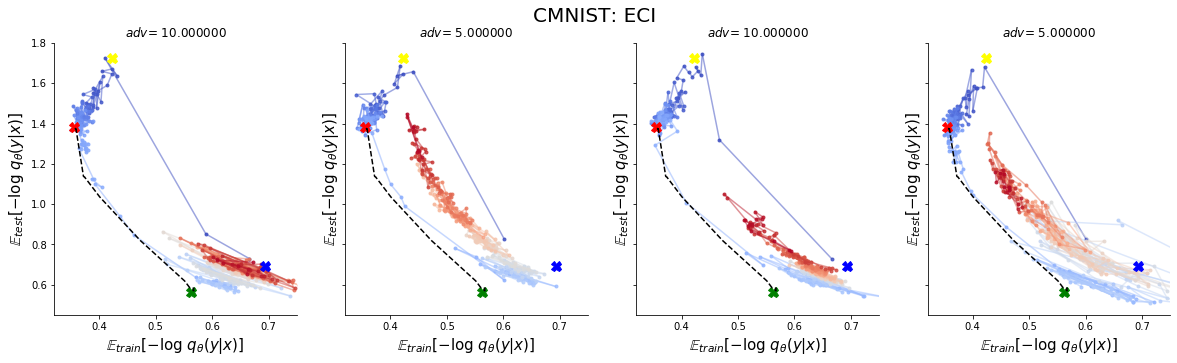

In [26]:
dataset = 'CMNIST'
model = 'ECI'

sweep = api.sweep('causal-mib/%s'%sweeps[dataset][model]['id'])

select = None
if 'select' in sweeps[dataset][model]:
    select = sweeps[dataset][model]['select']
    runs = [run for run in sweep.runs if run.config[select['name']] == select['value']]
else:
    runs = sweep.runs
    
title_param = None
if 'run_title' in sweeps[dataset][model]:
    title_param = sweeps[dataset][model]['run_title']['param']
    title_name = sweeps[dataset][model]['run_title']['name']

    

cmap = plt.get_cmap('coolwarm')

f, ax = plt.subplots(1,len(runs), figsize=(5*len(runs),5), sharex=True, sharey=True)
if len(sweep.runs)==1:
    ax = [ax]

sns.despine()

f.suptitle('%s: %s'%(dataset, model), size=20)

for j,run in enumerate(tqdm(runs)):
    
    if title_param:
        ax[j].set_title('%s= %f'%(title_name, run.config[title_param]))
        
    run_data = process_run[dataset]['sample'](run,10000)
    colors = np.array([cmap(v/run_data['step'].values.max()) for v in run_data['step'].values[:len(run_data['step'].values)]])
    
    
    for i in range(len(colors)):
        ax[j].plot(run_data['train'][i], run_data['test'][i],'.',color=colors[i], alpha=0.8)
        ax[j].plot(run_data['train'][i:i+2], run_data['test'][i:i+2],'-',color=colors[i], alpha=0.5)
        
    decorate_plot(t_results[dataset], ax[j])

        

        #ax[j].set_title(run_name, fontsize=20)

#ax[-1].legend(fontsize=12)

In [6]:
sweeps[dataset][model]

NameError: name 'dataset' is not defined

In [7]:


def plot_data(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    points = []
    for data in all_data:
        mu = np.mean(data, axis=0)
        sigma = np.cov(data, rowvar=0)

        U, s, _ = numpy.linalg.svd(sigma)

        ax.plot(mu[0],mu[1],'.', color=color)
        ax.plot([mu[0]-U[0,0]*s[0]**0.5,mu[0]+U[0,0]*s[0]**0.5],[mu[1]-U[0,1]*s[0]**0.5,mu[1]+U[0,1]*s[0]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        ax.plot([mu[0]-U[1,0]*s[1]**0.5,mu[0]+U[1,0]*s[1]**0.5],[mu[1]-U[1,1]*s[1]**0.5,mu[1]+U[1,1]*s[1]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        points.append(mu.reshape(1,-1))
    points = np.concatenate(points,0)
    ax.plot(points[:,0], points[:,1], color=color, label=label)    
    
    
def plot_data_points(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    all_data = pd.concat(all_data)
    
    x_min, x_max = all_data['train'].min(),all_data['train'].max()
    
    n = 3  # degree of polynomial
    p, C_p = np.polyfit(all_data['train'], all_data['test'], n, cov=True)  # C_z is estimated covariance matrix

    # Do the interpolation for plotting:
    t = np.linspace(x_min, x_max, 100)
    # Matrix with rows 1, t, t**2, ...:
    TT = np.vstack([t**(n-i) for i in range(n+1)]).T
    yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
    C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
    sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

    # Do the plotting:
    ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25, color=color) 
    ax.plot(t, yi,'-', color=color, label=label) 
    ax.plot(all_data['train'],all_data['test'],'.',color=color, alpha=0.1) 


def plot_sweep_result(runs, get_last_run_data, sortkey, ax, uncertainty_alpha=0.5, color=None, label=None, consider_last=1000):
    points = []
    reg_strenght = []
    all_data = [get_last_run_data(run, consider_last=consider_last) for run in runs]
    #sortby = [json.loads(run.json_config)[sortkey]['value'] for run in sweep.runs]
    #order = np.argsort(sortby)
    
    #print(order)
    if len(all_data)>0:
        plot_data_points(all_data, ax, color=color, uncertainty_alpha=uncertainty_alpha, label=label)



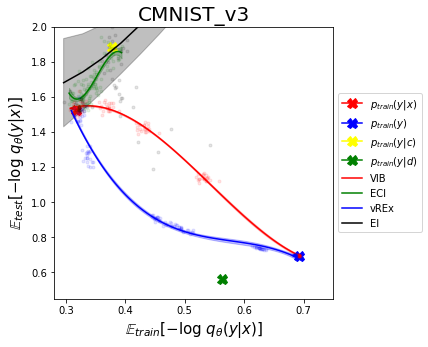

In [8]:

consider_last = 5000


datasets = [ 'CMNIST_v3']
#datasets = ['SpeechCommands']

f, ax = plt.subplots(1,len(datasets),figsize=(5*len(datasets),5))
if len(datasets)==1:
    ax=[ax]

for i, dataset in enumerate(tqdm(datasets)):
    decorate_plot(t_results[dataset], ax[i])
    

    for sweep_name, sweep_data in tqdm(sweeps[dataset].items()):
        sweep = api.sweep('causal-mib/%s' % sweep_data['id'])
        
        select = None
        if 'select' in sweeps[dataset][sweep_name]:
            select = sweeps[dataset][sweep_name]['select']
            runs = [run for run in sweep.runs if run.config[select['name']] == select['value']]
        else:
            runs = sweep.runs
        
        plot_sweep_result(runs, process_run[dataset]['get_last'], 
                          sortkey=sweep_data['sortkey'], ax=ax[i],
                          
                          color=sweep_data['color'], 
                          label=sweep_name, consider_last=consider_last)


    ax[i].set_title(dataset, size=20)
ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


Text(0, 0.5, '$\\mathbb{E}_{test}[-\\log\\ q_\\theta(y|x)]$')

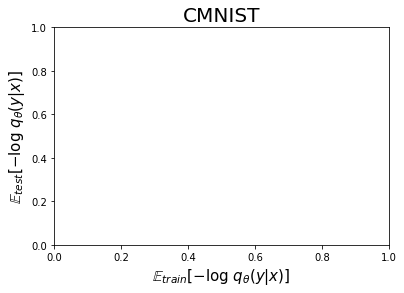

In [114]:
f, ax = plt.subplots(1,1)

ax.set_title('CMNIST', size=20)
ax.set_xlabel('$\\mathbb{E}_{train}[-\\log\\ q_\\theta(y|x)]$', size=15)
ax.set_ylabel('$\\mathbb{E}_{test}[-\\log\\ q_\\theta(y|x)]$', size=15)

In [18]:
from definitions.architectures.SpeechCommands import Encoder, LabelClassifier
import os

run = api.run('mfederici/causal-mib/jwaxtxsy')
checkpoint = 'model.pt'
download_dir = os.path.join('cache', checkpoint)

run.file(checkpoint).download(replace=True, root='cache')

encoder = Encoder(z_dim=64, dist='Delta', dropout=0.25, n_hidden=128)
classifier = LabelClassifier(z_dim=64, dropout=0, dist='Categorical', n_hidden=128)

state_dict = torch.load(download_dir, map_location=torch.device('cpu'))

In [24]:
labels = torch.ones(64).long().unsqueeze(1)
z = torch.zeros(64,64)

classifier(z).log_prob(labels.squeeze()).shape

torch.Size([64])

In [15]:
def get_pareto(points, n=100):
    alpha = np.linspace(0,np.pi/2,n)
    l = np.concatenate([np.cos(alpha).reshape(-1,1),np.sin(alpha).reshape(-1,1)],1)
    dist = np.abs(points @ l.T)
    min_dist_idx = np.argmin(dist, 0)
    return points[min_dist_idx,:]

In [36]:
points = np.random.normal(2,0.5,10000)
points = points.reshape(-1,2)

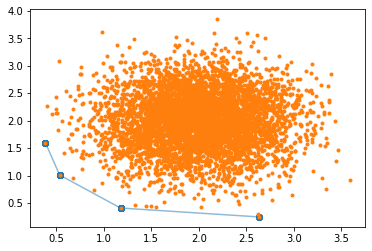

In [39]:

pareto = get_pareto(points, n=100)

plt.plot(pareto[:,0],pareto[:,1],'o-', alpha=0.5)
plt.plot(points[:,0],points[:,1],'.')


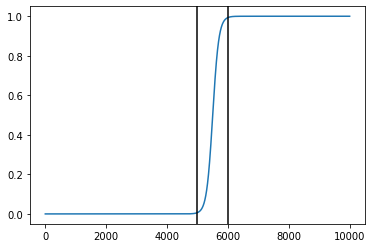

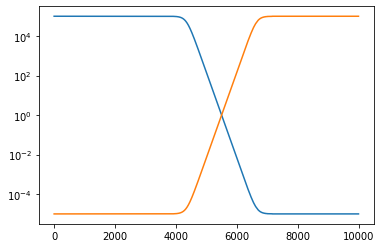

In [69]:
from torch import sigmoid

x = torch.FloatTensor(np.arange(0,10000))
scale = 1000
offset = 5000
start_value = 1e-5
end_value = 1-1e-5
s = scale/10

beta = start_value+sigmoid((x-offset-scale/2)/s)*(end_value-start_value)
plt.plot(x, beta)

plt.axvline(offset, color='k')
plt.axvline(offset+scale, color='k')
plt.show()

plt.plot(x, (1-beta)/beta)
plt.plot(x, beta/(1-beta))
plt.yscale('log')

In [74]:
iteration = 1

sigmoid(torch.FloatTensor([iteration])), 

(tensor([0.7311]), 0.7310585786300049)

In [17]:
run_data = run.scan_history()
last_beta = 1e-5

data = []

for row in run_data:
    if 'loss/beta' in row:
        beta = row['loss/beta']
        if beta==beta:
            last_beta = beta
    if 'test_ce_01' in row:
        if row['test_ce_01']==row['test_ce_01']:
            data.append({
                'beta':last_beta,
                'train_ce': 0.5*(row['test_ce_01']+row['test_ce_02']),
                'test_ce': row['test_ce_09']
            })

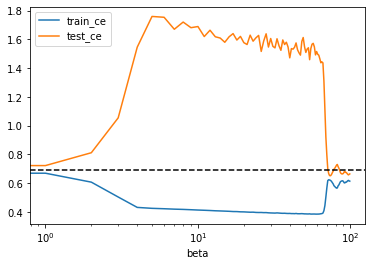

In [113]:
f, ax = plt.subplots(1,1)

pd.DataFrame(data).plot(x='beta',y='train_ce', ax=ax)
pd.DataFrame(data).plot(x='beta',y='test_ce', ax=ax)
ax.axhline(np.log(2), ls='--', color='k')
ax.set_xscale('log')

# Dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Loading the MNIST train and test set
train_set = MNIST('/data/MNIST', download=True, train=True, transform=ToTensor())
test_set = MNIST('/data/MNIST', download=True, train=False, transform=ToTensor())

In [3]:
from torchvision.transforms import Compose, RandomAffine, ToTensor
from utils.data import PixelCorruption

# Defining the augmentations
t = Compose([
    RandomAffine(degrees=15,
                 translate=[0.1, 0.1],
                 scale=[0.9, 1.1],
                 shear=15), # Small affine transformations
    ToTensor(),             # Conversion to torch tensor
    PixelCorruption(0.8)    # PixelCorruption with keep probability 80%
])

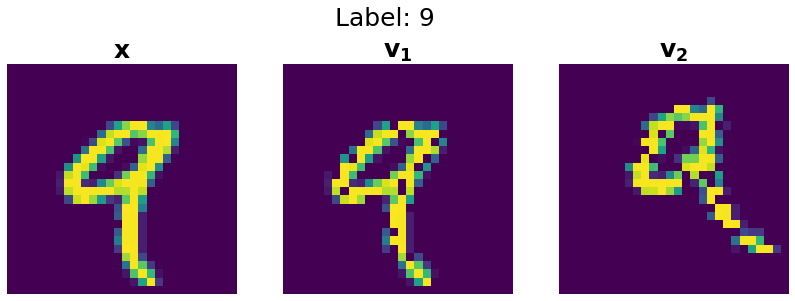

In [4]:
from utils.data import AugmentedDataset

# Creating the multi-view dataset
mv_train_set = AugmentedDataset(MNIST('/data/MNIST', train=True), t)

# Visualization original data and the two augmented views
f, ax = plt.subplots(1,3, figsize=(14,5))

idx = 4
v_1, v_2, y = mv_train_set[idx]
x, _ = train_set[idx]
f.suptitle('Label: %d'%y,size=25)

ax[0].set_title('$\\bf x$', size=25)
ax[0].imshow(x[0])

ax[1].set_title('$\\bf v_1$', size=25)
ax[1].imshow(v_1[0].data.numpy())

ax[2].set_title('$\\bf v_2$', size=25)
ax[2].imshow(v_2[0].data.numpy())


for a in ax:
    a.axis('off')

# Evaluation

In [5]:
from utils.evaluation import EmbeddedDataset
from utils.modules import Encoder
import os

# Encoder architecture
encoder = Encoder(z_dim = 64)

device = 'cuda' # Change to 'cpu' to perform the evaluation on CPU

encoder.eval()

Encoder(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=128, bias=True)
  )
)

VAE
-Embedding the dataset
-Computing classifier accuracy
InfoMax
-Embedding the dataset
-Computing classifier accuracy
MV-InfoMax
-Embedding the dataset
-Computing classifier accuracy
MIB
-Embedding the dataset
-Computing classifier accuracy


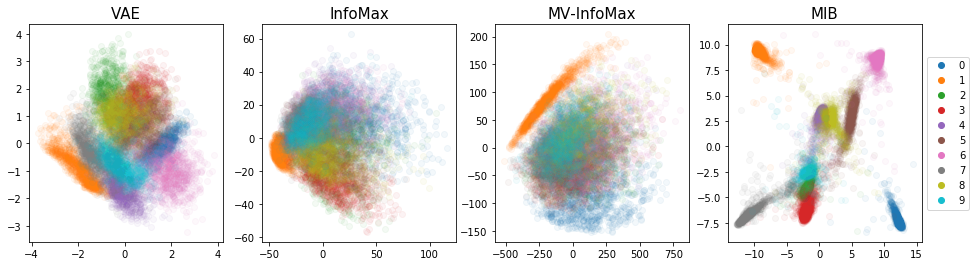

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from utils.evaluation import build_matrix

# Root containing the pre-trained models
model_path = 'trained_models'

# This comparison includes 
trained_models = [
    'VAE.pt',             # Beta Variational Autoencoder (Beta=4)
    'InfoMax.pt',         # InfoMax
    'MV-InfoMax.pt',      # Multi-View InfoMax
    'MIB.pt'              # Multi-View Information Bottleneck (Beta=1)
]
# The different models shown in this examples have been trained for a total of 1000 epochs

# Definition of axis and PCA for a qualitative visualization
f, ax = plt.subplots(1,len(trained_models),figsize=(len(trained_models) * 4, 4))
pca = PCA(n_components=2) 

# Definition of scaler and Logistic classifier used to evaluate the different representations
scaler = MinMaxScaler()
classifier = LogisticRegression(solver='saga', multi_class='multinomial', C=10, tol=.1)

# Each representation will be tested by training the logistic classifier on different
# number of given labels. In order to estimate the variance, each experiment
# will be performed 100 times on different balanced train sub-sets
repetitions = 100
examples_per_labels = [1, 2, 5, 10, 100, 1000]

accuracy_results = []

for i, model_file in enumerate(trained_models):    
    model_name = model_file.split('.')[0]
    print(model_name)
    
    # Load the parameters from a trained model
    state_dict = torch.load(os.path.join(model_path, model_file))['encoder']
    encoder.load_state_dict(state_dict)
    
    print('-Embedding the dataset')
        
    # Embed train and test set using the learned encoder
    embedded_train_set = EmbeddedDataset(base_dataset=train_set, encoder=encoder, device=device)
    embedded_test_set = EmbeddedDataset(base_dataset=test_set, encoder=encoder, device=device)
    
    # Convert the two sets into 2D matrices for evaluation
    X_train, Y_train = build_matrix(embedded_train_set)
    X_test, Y_test = build_matrix(embedded_test_set)
    
    # Project the test set on the principal components
    projected_X_test = pca.fit_transform(X_test)
    
    # And plot the representation with different colors corresponding to the different labels
    ax[i].set_title(model_name, size=15)
    for label in range(10):
        selected_X_test = projected_X_test[Y_test==label]
        ax[i].plot(selected_X_test[:,0], selected_X_test[:,1], 'o', label=label, alpha=0.05)
    
    print('-Computing classifier accuracy')
    
    # Scale train and test set
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Repeat multiple time to obtain a better estimation
    for i in range(repetitions):
        for examples_per_label in examples_per_labels:
            # Randomly select examples_per_label examples for each one of the 10 labels
            # to create a labeled training sub-set
            selected_ids = []
            for label in range(10):
                ids_with_label = np.arange(len(Y_train))[Y_train == label]
                selected_id = np.random.choice(ids_with_label, examples_per_label, replace=False)
                selected_ids.append(selected_id)
            selected_ids = np.concatenate(selected_ids)

            # Fit the linear classifier on the selection
            classifier.fit(X_train[selected_ids], Y_train[selected_ids])

            # Evaluate the classifier on the embedded test set
            test_accuracy = classifier.score(X_test, Y_test)

            accuracy_results.append({
                'Number of Labels': examples_per_label * 10,
                'Test Accuracy': test_accuracy,
                'Model': model_name
            })
    
    
# Add a legend to the last plot
leg = ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_marker('o')

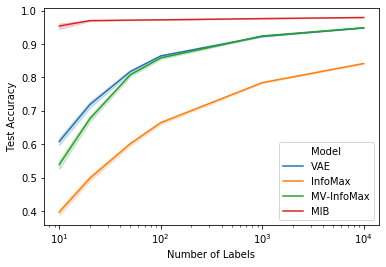

In [7]:
import pandas as pd
import seaborn as sns

# Visualize the accuracy of the classifier for different percentages of training labels
accuracy_results_df = pd.DataFrame(accuracy_results)

f, ax = plt.subplots(1,1)

sns.lineplot(data=accuracy_results_df, x='Number of Labels', y='Test Accuracy', hue='Model', ax=ax)
ax.set_xscale('log')